In [29]:
import torch 
import torch.nn.functional as F # stateless contains functions 
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [30]:
# names dataset
names = open("names.txt", "r").read().splitlines()

In [31]:
# mapping from characters to strings
chars = sorted(list(set(''.join(names)))) # flatten list of names into a single string
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [32]:
# build dataset of n grams
context_size = 3 

def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * context_size
        for ch in name + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index] # update context
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y        

In [33]:
# create train, test, split sets
random.seed(42)
random.shuffle(names)

#Splits
split1 = int(0.8 * len(names))
split2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:split1]) # train set: 80%
Xdev, Ydev = build_dataset(names[split1:split2]) # validation set: 10%
Xte, Yte = build_dataset(names[split2:]) # test set: 10%

In [34]:
# MLP

# Hyperparameters
n_emb = 10 # dimensionality of char embedding vector
n_hidden = 200 # no of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)

# Model Paramters
C = torch.randn((vocab_size, n_emb), generator=g) # embedding matrix
W1 = torch.randn((n_emb * context_size, n_hidden), generator=g) # inputs and outputs of wights 
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

# Require gradient
for p in parameters:
    p.requires_grad = True

In [35]:
# optimization parameters
iterations = 200000
batch_size = 32
lossi = []

for i in range (iterations):
    # minibatch
    indexes = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # get batch_size no of indexes 
    Xb, Yb = Xtr[indexes], Ytr[indexes]

    # forward pass
    emb = C[Xb] # embeddings for batch
    emb_cat = emb.view(emb.shape[0],-1) # concatenate embeddings
    hpreact = emb_cat @ W1 + b1 # preactivation (weights dot product embeddings + bias)
    h = torch.tanh(hpreact) # tanh of preactivation so output is between (-1, 1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # softmax + negative log likelihood

    # backward pass
    for p in parameters:
        p.grad = None # reset gradients
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track loss
    if i % 10000 == 0:
        print(f'{i:7d}/{iterations:7d}: {loss.item():.4f}')
    lossi.append (loss.log10().item())
    


      0/ 200000: 27.8817
  10000/ 200000: 2.8902
  20000/ 200000: 2.5398
  30000/ 200000: 2.6638
  40000/ 200000: 2.0514
  50000/ 200000: 2.4889
  60000/ 200000: 2.4369
  70000/ 200000: 2.1046
  80000/ 200000: 2.3162
  90000/ 200000: 2.1146
 100000/ 200000: 1.9779
 110000/ 200000: 2.5229
 120000/ 200000: 2.1334
 130000/ 200000: 2.5325
 140000/ 200000: 2.3501
 150000/ 200000: 2.2304
 160000/ 200000: 2.3085
 170000/ 200000: 1.8291
 180000/ 200000: 2.3020
 190000/ 200000: 2.0512


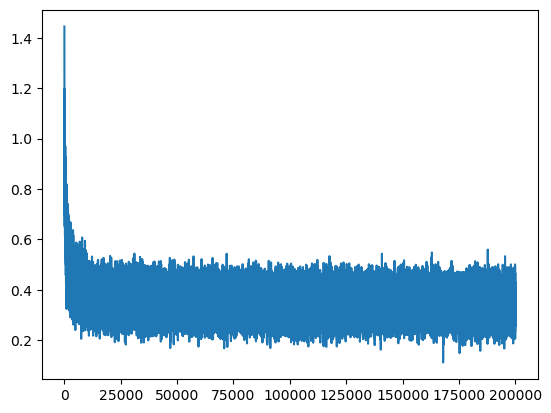

In [36]:
plt.plot(lossi)

In [ ]:
# Calculate losses on splits
@torch.no_grad() # decorater to disable gradient tracking, so model does not update parameters
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print (split, loss.item())

split_loss('train')
split_loss('val')


train 2.230722427368164
val 2.250082015991211


In [38]:
# Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (20):
    out = []
    context = [0] * context_size
    while (True):
        # Forward pass
        lookup = C[torch.tensor(context)]
        emb = lookup.view(1, -1)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        # sample
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        # update context
        context = context[1:] + [index]
        out.append(index)

        if index == 0:
            break
    print(''.join(itos[i] for i in out))


carlah.
amorilli.
kemri.
rehty.
sacessaeja.
hutefaresarti.
aqui.
nellara.
chaiir.
kaleig.
dham.
jorn.
quint.
sroel.
alian.
quinaelo.
dearynixfi.
everludi.
edde.
oia.
